In [199]:
# -*- coding: utf-8 -*-
import dataiku
import pandas as pd, numpy as np
from dataiku import pandasutils as pdu

from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import time

t0 = time.time()

print("loading...")

# Read recipe inputs
NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT = dataiku.Dataset("NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT")
NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT_df = NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT.get_dataframe()

NAFCUSTOMER_REVENUE_AGGREGATED = dataiku.Dataset("NAFCUSTOMER_REVENUE_AGGREGATED")
NAFCUSTOMER_REVENUE_AGGREGATED_df = NAFCUSTOMER_REVENUE_AGGREGATED.get_dataframe()

t1 = time.time()
print("load duration", (t1-t0)/60.0, "minutes")

loading...
load duration 10.291395437717437 minutes


In [200]:
print(len(NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT_df), "rows in NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT")
df_a = NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT_df.copy()

print(len(NAFCUSTOMER_REVENUE_AGGREGATED_df), "rows in NAFCUSTOMER_REVENUE_AGGREGATED")
df = NAFCUSTOMER_REVENUE_AGGREGATED_df.copy()
df = df[df.REVENUE_YEAR!=2023]
print(len(df))

2319568 rows in NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT
18075044 rows in NAFCUSTOMER_REVENUE_AGGREGATED
17673397


In [201]:
df.head()

,CUSTOMER_ID,CUSTOMER,REVENUE_YEAR,REVENUE_MONTH,SETUP_DATE,BI_CUS_PAR,BI_PRODUCT,BI_MRU,REVENUE_AMOUNT_USD,GROSS_SPEND_AMOUNT,PURCHASE_GALLONS_QTY,TOTAL_ACTIVE_CARD_COUNT
0,77640633.0,WINE UNIVERSE CORP,2020,10,2017-08-07 07:00:00+00:00,53000.0,10100.0,4120.0,86.75,62.98,23.330,1.0
1,77579104.0,THE CHIMNEY SWEEP INC,2019,7,2014-08-05 07:00:00+00:00,10500.0,15100.0,4120.0,308.22,2582.54,1020.587,3.0
2,77133878.0,CITY OF FOREST HILLS,2022,11,2018-11-01 07:00:00+00:00,21000.0,15100.0,4000.0,4.10,631.11,193.750,2.0
3,77131052.0,CHRISTIAN FARMS TREEHOUSE,2022,4,2020-01-18 08:00:00+00:00,12900.0,15110.0,4000.0,1.43,167.80,46.448,1.0
4,77608172.0,TWT LEASING INC,2021,3,2012-09-02 07:00:00+00:00,11300.0,15100.0,4120.0,44.23,1180.54,452.433,2.0


In [202]:
df_revenue_by_customer_and_year = df.groupby(['CUSTOMER_ID','CUSTOMER','REVENUE_YEAR']).REVENUE_AMOUNT_USD.sum().reset_index()
print(len(df_revenue_by_customer_and_year))

df_spend_by_customer_and_year = df.groupby(['CUSTOMER_ID','CUSTOMER','REVENUE_YEAR']).GROSS_SPEND_AMOUNT.sum().reset_index()
print(len(df_spend_by_customer_and_year))

df_active_card_count_by_customer = df_a.groupby(['CUSTOMER_ID','CUSTOMER','YEAR_NUMBER']).ACTIVE_CARD_COUNT.sum().reset_index()
df_active_card_count_by_customer.columns = ['CUSTOMER_ID','CUSTOMER','REVENUE_YEAR','ACTIVE_CARD_COUNT']
print(len(df_active_card_count_by_customer))

df_customer_fleet_size = df_active_card_count_by_customer.groupby(['CUSTOMER_ID','CUSTOMER']).ACTIVE_CARD_COUNT.max().reset_index()
df_customer_fleet_size.columns = ['CUSTOMER_ID', 'CUSTOMER', 'FLEET_SIZE']
print(len(df_customer_fleet_size))

1777729
1777729
1771976
649448


In [203]:
print(len(df_revenue_by_customer_and_year))
df_j = pd.merge(df_revenue_by_customer_and_year,df_spend_by_customer_and_year,how='left',on=['CUSTOMER_ID','CUSTOMER','REVENUE_YEAR'])
print(len(df_j))

df_j = pd.merge(df_j,df_active_card_count_by_customer,how='left',on=['CUSTOMER_ID','CUSTOMER','REVENUE_YEAR'])
print(len(df_j))

df_j = pd.merge(df_j,df_customer_fleet_size, how='left',on=['CUSTOMER_ID','CUSTOMER'])
print(len(df_j))

df_j.loc[df_j.ACTIVE_CARD_COUNT.isnull(),'ACTIVE_CARD_COUNT'] = 0
df_j.loc[df_j.FLEET_SIZE.isnull(),'FLEET_SIZE'] = 0

df_j['FLEET_CATEGORY'] = 'NOT SET'
df_j.loc[df_j.FLEET_SIZE.between(0,5),'FLEET_CATEGORY'] = '(<=5 cards)'
df_j.loc[df_j.FLEET_SIZE.between(6,100),'FLEET_CATEGORY'] = '(between 6 and 100 cards)'
df_j.loc[df_j.FLEET_SIZE>50,'FLEET_CATEGORY'] = '(>100 cards)'
df_j.head()

1777729
1777729
1777729
1777729


,CUSTOMER_ID,CUSTOMER,REVENUE_YEAR,REVENUE_AMOUNT_USD,GROSS_SPEND_AMOUNT,ACTIVE_CARD_COUNT,FLEET_SIZE,FLEET_CATEGORY
0,77000000.0,1 AUTO PARTS INC,2019,175.47,0.00,1.0,1.0,(<=5 cards)
1,77000001.0,94775 J AND J SNACK FOODS AA,2022,74.15,3318.62,3.0,3.0,(<=5 cards)
2,77000002.0,APOSTROPHE DESIGN INC,2019,177.47,8944.23,4.0,8.0,(between 6 and 100 cards)
3,77000002.0,APOSTROPHE DESIGN INC,2020,271.60,10358.34,4.0,8.0,(between 6 and 100 cards)
4,77000002.0,APOSTROPHE DESIGN INC,2021,243.51,13094.44,8.0,8.0,(between 6 and 100 cards)


In [204]:
df_j.FLEET_CATEGORY.unique()

array(['(<=5 cards)', '(between 6 and 100 cards)', '(>100 cards)'],
      dtype=object)

In [205]:
df_revenue_by_year = df_j.groupby(['REVENUE_YEAR','FLEET_CATEGORY']).REVENUE_AMOUNT_USD.sum().reset_index()
df_revenue_by_year.head(10)

,REVENUE_YEAR,FLEET_CATEGORY,REVENUE_AMOUNT_USD
0,2019,(<=5 cards),5.682940e+07
1,2019,(>100 cards),2.791009e+08
2,2019,(between 6 and 100 cards),2.759561e+08
3,2020,(<=5 cards),4.892064e+07
4,2020,(>100 cards),2.233491e+08
5,2020,(between 6 and 100 cards),2.366673e+08
6,2021,(<=5 cards),6.461378e+07
7,2021,(>100 cards),2.769536e+08
8,2021,(between 6 and 100 cards),2.915809e+08
9,2022,(<=5 cards),9.994466e+07


In [206]:
df_revenue_by_year.REVENUE_YEAR.value_counts()

2022    3
2021    3
2020    3
2019    3
Name: REVENUE_YEAR, dtype: int64

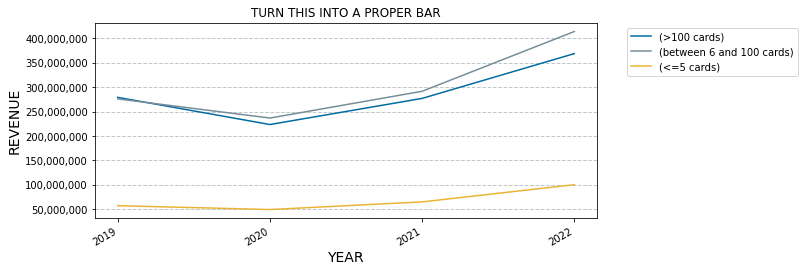

In [207]:
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

fig, ax1 = plt.subplots(figsize=(9,4))

#['(<=5 cards)', '(between 6 and 100 cards)', '(>100 cards)']

dim1 = list(map(str,df_revenue_by_year[df_revenue_by_year.FLEET_CATEGORY=='(>100 cards)'].REVENUE_YEAR))
data1 = df_revenue_by_year[df_revenue_by_year.FLEET_CATEGORY=='(>100 cards)'].REVENUE_AMOUNT_USD

dim2 = list(map(str,df_revenue_by_year[df_revenue_by_year.FLEET_CATEGORY=='(between 6 and 100 cards)'].REVENUE_YEAR))
data2 = df_revenue_by_year[df_revenue_by_year.FLEET_CATEGORY=='(between 6 and 100 cards)'].REVENUE_AMOUNT_USD

dim3 = list(map(str,df_revenue_by_year[df_revenue_by_year.FLEET_CATEGORY=='(<=5 cards)'].REVENUE_YEAR))
data3 = df_revenue_by_year[df_revenue_by_year.FLEET_CATEGORY=='(<=5 cards)'].REVENUE_AMOUNT_USD

#ax1.bar(dim1,data1, color='#006BA2', width=0.75)
#ax1.bar(dim2,data2, bottom=data1, color='#758D99', width=0.75)
#ax1.bar(dim3,data3, bottom=data2+data1, color='#EBB434', width=0.75)

ax1.plot(dim1,data1, color='#006BA2')
ax1.plot(dim2,data2, color='#758D99')
ax1.plot(dim3,data3, color='#EBB434')

ax1.set_xlabel('YEAR', fontsize=14)
ax1.set_ylabel('REVENUE', fontsize=14)
#ax1.set_ylim(ymin=0, ymax=max_value*1.15)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='y', alpha=0.6)
fig.autofmt_xdate()
plt.title('TURN THIS INTO A PROPER BAR')
plt.legend(['(>100 cards)','(between 6 and 100 cards)','(<=5 cards)'], bbox_to_anchor=(1.05,1.0), loc='upper left')
plt.show()

In [208]:
df_revenue_by_year.head()

,REVENUE_YEAR,FLEET_CATEGORY,REVENUE_AMOUNT_USD
0,2019,(<=5 cards),5.682940e+07
1,2019,(>100 cards),2.791009e+08
2,2019,(between 6 and 100 cards),2.759561e+08
3,2020,(<=5 cards),4.892064e+07
4,2020,(>100 cards),2.233491e+08


ValueError: operands could not be broadcast together with shapes (3,) (0,) 

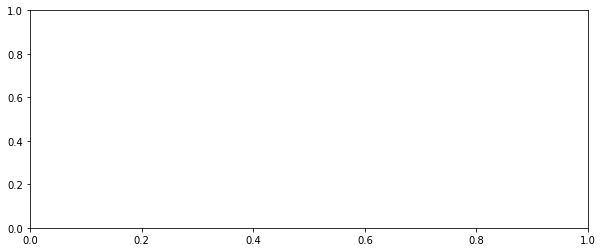

In [216]:
colors = ['#006BA2','#758D99','#EBB434']
labels = ['(<=5 cards)','(between 6 and 100 cards)','(>100 cards)']

fig, ax = plt.subplots(1, figsize=(10,4))

bottom = len(labels) * [0]
for idx,s in enumerate(labels):
    
    dim1 = list(map(str,df_spend_by_year[df_spend_by_year.FLEET_CATEGORY==s].REVENUE_YEAR))
    data1 = df_spend_by_year[df_spend_by_year.FLEET_CATEGORY==s].GROSS_SPEND_AMOUNT
    
    #bottom = bottom + data1
    
    #plt.bar(dim1, data1, bottom=bottom,)
    
    print(idx)
    print(s)
    print(dim1)
    print(data1)
    print(bottom)

In [0]:
df_spend_by_year = df_j.groupby(['REVENUE_YEAR','FLEET_CATEGORY']).GROSS_SPEND_AMOUNT.sum().reset_index()
df_spend_by_year.head(10)

In [0]:
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

fig, ax1 = plt.subplots(figsize=(9,4))

dim1 = list(map(str,df_spend_by_year[df_spend_by_year.FLEET_CATEGORY=='(>20 cards)'].REVENUE_YEAR))
data1 = df_spend_by_year[df_spend_by_year.FLEET_CATEGORY=='(>20 cards)'].GROSS_SPEND_AMOUNT

dim2 = list(map(str,df_spend_by_year[df_spend_by_year.FLEET_CATEGORY=='(<=20 cards)'].REVENUE_YEAR))
data2 = df_spend_by_year[df_spend_by_year.FLEET_CATEGORY=='(<=20 cards)'].GROSS_SPEND_AMOUNT

ax1.bar(dim1,data1, color='#006BA2', width=0.75)
ax1.bar(dim2,data2, bottom=data1, color='#758D99', width=0.75)

ax1.set_xlabel('YEAR', fontsize=14)
ax1.set_ylabel('SPEND', fontsize=14)
#ax1.set_ylim(ymin=0, ymax=max_value*1.15)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='y', alpha=0.6)
fig.autofmt_xdate()
plt.title('SPEND by YEAR')
plt.legend(['(>20 cards)','(<=20 cards)'], bbox_to_anchor=(1.05,1.0), loc='upper left')
plt.show()

In [0]:
df_customer_by_year = df_j.groupby(['REVENUE_YEAR','FLEET_CATEGORY']).CUSTOMER_ID.nunique().reset_index()
df_customer_by_year.columns = ['REVENUE_YEAR', 'FLEET_CATEGORY', 'CUSTOMER_COUNT']
df_customer_by_year.head(10)

In [0]:
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

fig, ax1 = plt.subplots(figsize=(9,4))

dim1 = list(map(str,df_customer_by_year[df_customer_by_year.FLEET_CATEGORY=='(>20 cards)'].REVENUE_YEAR))
data1 = df_customer_by_year[df_customer_by_year.FLEET_CATEGORY=='(>20 cards)'].CUSTOMER_COUNT

dim2 = list(map(str,df_customer_by_year[df_customer_by_year.FLEET_CATEGORY=='(<=20 cards)'].REVENUE_YEAR))
data2 = df_customer_by_year[df_customer_by_year.FLEET_CATEGORY=='(<=20 cards)'].CUSTOMER_COUNT

ax1.bar(dim1,data1, color='#006BA2', width=0.75)
ax1.bar(dim2,data2, bottom=data1, color='#758D99', width=0.75)

ax1.set_xlabel('YEAR', fontsize=14)
ax1.set_ylabel('CUSTOMER COUNT', fontsize=14)
#ax1.set_ylim(ymin=0, ymax=max_value*1.15)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='y', alpha=0.6)
fig.autofmt_xdate()
plt.title('CUSTOMER COUNT by YEAR')
plt.legend(['(>20 cards)','(<=20 cards)'], bbox_to_anchor=(1.05,1.0), loc='upper left')
plt.show()

In [0]:
df_active_cards_by_year = df_j.groupby(['REVENUE_YEAR','FLEET_CATEGORY']).ACTIVE_CARD_COUNT.sum().reset_index()
df_active_cards_by_year.head(10)

In [0]:
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

fig, ax1 = plt.subplots(figsize=(9,4))

dim1 = list(map(str,df_active_cards_by_year[df_active_cards_by_year.FLEET_CATEGORY=='(>20 cards)'].REVENUE_YEAR))
data1 = df_active_cards_by_year[df_active_cards_by_year.FLEET_CATEGORY=='(>20 cards)'].ACTIVE_CARD_COUNT

dim2 = list(map(str,df_active_cards_by_year[df_active_cards_by_year.FLEET_CATEGORY=='(<=20 cards)'].REVENUE_YEAR))
data2 = df_active_cards_by_year[df_active_cards_by_year.FLEET_CATEGORY=='(<=20 cards)'].ACTIVE_CARD_COUNT

ax1.bar(dim1,data1, color='#006BA2', width=0.75)
ax1.bar(dim2,data2, bottom=data1, color='#758D99', width=0.75)

ax1.set_xlabel('YEAR', fontsize=14)
ax1.set_ylabel('ACTIVE CARDS', fontsize=14)
#ax1.set_ylim(ymin=0, ymax=max_value*1.15)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='y', alpha=0.6)
fig.autofmt_xdate()
plt.title('ACTIVE CARD COUNT by YEAR')
plt.legend(['(>20 cards)','(<=20 cards)'], bbox_to_anchor=(1.05,1.0), loc='upper left')
plt.show()

In [0]:
# Compute recipe outputs
# TODO: Write here your actual code that computes the outputs
# NB: DSS supports several kinds of APIs for reading and writing data. Please see doc.

#RETENTION_RATE_BY_GROUP_df = ... # Compute a Pandas dataframe to write into RETENTION_RATE_BY_GROUP

# Write recipe outputs
#RETENTION_RATE_BY_GROUP = dataiku.Dataset("RETENTION_RATE_BY_GROUP")
#RETENTION_RATE_BY_GROUP.write_with_schema(RETENTION_RATE_BY_GROUP_df)